# Business Objective

We want to retain customers who are worth retaining. We want to identify them before they leave because it is cheaper to retain than reaquire them.

# EDA

First step: load, clean, and explore the data to see if anything nasty is lurky out there in the wilds.

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
from scipy import stats as sp
from pandas.plotting import scatter_matrix

In [2]:
df = pd.read_csv('data/churn.csv')

In [26]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [17]:
start_date = pd.to_datetime('2014-07-01', format='%Y-%m-%d')
start_date -= datetime.timedelta(30, 0, 0)
start_date

Timestamp('2014-06-01 00:00:00')

## Data hygiene

In [24]:
df.last_trip_date = pd.to_datetime(df.last_trip_date, format='%Y-%m-%d')
df.signup_date = pd.to_datetime(df.signup_date, format='%Y-%m-%d')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(1)
memory usage: 3.6 MB


In [27]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [28]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [37]:
df.phone = df.phone.fillna('no_phone')
df.phone = df.phone.astype('category')
df.city = df.city.astype('category')
df.phone.value_counts()

iPhone      34582
Android     15022
no_phone      396
Name: phone, dtype: int64

### Check conversion

In [39]:
pd.crosstab(df.phone, df.city)

city,Astapor,King's Landing,Winterfell
phone,,,
Android,5244,2498,7280
iPhone,11169,7568,15845
no_phone,121,64,211


## Create labes/target/outcome

Add churn indicator. Considered to churn if have not taken a trip in the last 30 days.

In [44]:
df['is_active'] = start_date < df.last_trip_date
df.is_active.value_counts(dropna=False)

False    31690
True     18310
Name: is_active, dtype: int64

In [46]:
df['b_churned'] = -df.is_active
df.b_churned.value_counts(dropna=False)

True     31690
False    18310
Name: b_churned, dtype: int64

In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


In [49]:
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,is_active,b_churned
avg_dist,1.000000,0.080540,0.034509,-0.081491,-0.104414,-0.136329,0.032310,0.101652,-0.090279,0.090279
avg_rating_by_driver,0.080540,1.000000,0.123175,0.010597,0.020103,-0.039115,0.009343,0.020442,-0.025635,0.025635
avg_rating_of_driver,0.034509,0.123175,1.000000,-0.026189,-0.003899,-0.011302,-0.002086,0.014630,-0.010834,0.010834
avg_surge,-0.081491,0.010597,-0.026189,1.000000,0.793582,-0.001841,-0.078791,-0.110071,-0.003567,0.003567
surge_pct,-0.104414,0.020103,-0.003899,0.793582,1.000000,0.005720,-0.106861,-0.144918,0.010612,-0.010612
trips_in_first_30_days,-0.136329,-0.039115,-0.011302,-0.001841,0.005720,1.000000,0.112210,0.050388,0.214728,-0.214728
luxury_car_user,0.032310,0.009343,-0.002086,-0.078791,-0.106861,0.112210,1.000000,0.035998,0.210259,-0.210259
weekday_pct,0.101652,0.020442,0.014630,-0.110071,-0.144918,0.050388,0.035998,1.000000,0.026413,-0.026413
is_active,-0.090279,-0.025635,-0.010834,-0.003567,0.010612,0.214728,0.210259,0.026413,1.000000,-1.000000
b_churned,0.090279,0.025635,0.010834,0.003567,-0.010612,-0.214728,-0.210259,-0.026413,-1.000000,1.000000


## Checking dates

In [54]:
np.any(df.last_trip_date < df.signup_date)

False

See what distribution of signup dates looks like

In [59]:
df['signup_year'] = df.signup_date.apply(lambda x: x.year)
df['signup_month'] = df.signup_date.apply(lambda x: x.month)

In [61]:
pd.crosstab(df.signup_year, df.signup_month)

signup_month,1
signup_year,
2014,50000


In [62]:
df.signup_date.describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [64]:
df['last_trip_year'] = df.last_trip_date.apply(lambda x: x.year)
df['last_trip_month'] = df.last_trip_date.apply(lambda x: x.month)
pd.crosstab(df.last_trip_month, df.last_trip_year)

last_trip_year,2014
last_trip_month,
1,10147
2,4308
3,4568
4,4588
5,7585
6,18256
7,548


In [69]:
dftmp = df[df.last_trip_month == 6]
dftmp['last_trip_day'] = dftmp.last_trip_date.apply(lambda x: x.day)

/Users/alexseong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [70]:
dftmp.last_trip_day.value_counts()

29    2036
28    1679
30    1408
27    1120
22    1024
21     869
26     793
14     665
15     647
20     612
25     603
23     546
7      534
8      527
1      494
19     455
24     440
13     438
18     400
12     351
6      314
16     310
11     297
17     296
5      262
9      262
10     244
4      240
2      208
3      182
Name: last_trip_day, dtype: int64

In [76]:
df.groupby(['is_active','last_trip_month']).mean().T

is_active                     False                                         \
last_trip_month                   1            2            3            4   
avg_dist                   6.816549     6.038006     5.882500     6.038993   
avg_rating_by_driver       4.806602     4.778979     4.778203     4.773951   
avg_rating_of_driver       4.633324     4.585495     4.591581     4.599419   
avg_surge                  1.078925     1.089396     1.085274     1.060728   
surge_pct                  8.926274     9.338649     8.715740     7.656168   
trips_in_first_30_days     1.710161     2.112813     1.290061     1.378814   
luxury_car_user            0.287868     0.305942     0.318739     0.318221   
weekday_pct               59.999704    61.031848    57.635924    62.013622   
b_churned                  1.000000     1.000000     1.000000     1.000000   
signup_year             2014.000000  2014.000000  2014.000000  2014.000000   
signup_month               1.000000     1.000000     1.000000     1.000000   
last_trip_year          2014.000000  2014.000000  2014.000000  2014.000000   

is_active                                               True                
last_trip_month                   5            6            6            7  
avg_dist                   5.788456     4.959534     5.147640     4.189927  
avg_rating_by_driver       4.780513     4.749797     4.763216     4.760036  
avg_rating_of_driver       4.602883     4.576047     4.592054     4.633271  
avg_surge                  1.065413     1.077105     1.073605     1.077464  
surge_pct                  8.519684    10.065789     9.094961    10.204380  
trips_in_first_30_days     1.722347     1.702429     3.291071     5.246350  
luxury_car_user            0.290310     0.279352     0.511316     0.505474  
weekday_pct               62.281239    30.789474    61.948897    70.826825  
b_churned                  1.000000     1.000000     0.000000     0.000000  
signup_year             2014.000000  2014.000000  2014.000000  2014.000000  
signup_month               1.000000     1.000000     1.000000     1.000000  
last_trip_year          2014.000000  2014.000000  2014.000000  2014.000000

In [85]:
df.groupby(['is_active','last_trip_month']).quantile(0.5)

0.5                        avg_dist  avg_rating_by_driver  \
is_active last_trip_month                                   
False     1                   4.240                   5.0   
          2                   3.865                   5.0   
          3                   3.825                   5.0   
          4                   4.150                   5.0   
          5                   3.970                   5.0   
          6                   3.740                   5.0   
True      6                   3.740                   4.8   
          7                   3.405                   4.8   

0.5                        avg_rating_of_driver  avg_surge  b_churned  \
is_active last_trip_month                                               
False     1                                 5.0       1.00        1.0   
          2                                 5.0       1.00        1.0   
          3                                 5.0       1.00        1.0   
          4                                 5.0       1.00        1.0   
          5                                 4.9       1.00        1.0   
          6                                 4.9       1.00        1.0   
True      6                                 4.8       1.00        0.0   
          7                                 4.8       1.04        0.0   

0.5                        last_trip_year  luxury_car_user  signup_month  \
is_active last_trip_month                                                  
False     1                        2014.0              0.0           1.0   
          2                        2014.0              0.0           1.0   
          3                        2014.0              0.0           1.0   
          4                        2014.0              0.0           1.0   
          5                        2014.0              0.0           1.0   
          6                        2014.0              0.0           1.0   
True      6                        2014.0              1.0           1.0   
          7                        2014.0              1.0           1.0   

0.5                        signup_year  surge_pct  trips_in_first_30_days  \
is_active last_trip_month                                                   
False     1                     2014.0       0.00                     1.0   
          2                     2014.0       0.00                     1.0   
          3                     2014.0       0.00                     0.0   
          4                     2014.0       0.00                     0.0   
          5                     2014.0       0.00                     1.0   
          6                     2014.0       0.00                     1.0   
True      6                     2014.0       0.00                     2.0   
          7                     2014.0       6.85                     3.0   

0.5                        weekday_pct  
is_active last_trip_month               
False     1                      100.0  
          2                       66.7  
          3                       66.7  
          4                       66.7  
          5                       66.7  
          6                       30.0  
True      6                       64.7  
          7                       68.9

In [86]:
df.groupby(['is_active','last_trip_month']).std()

avg_dist  avg_rating_by_driver  \
is_active last_trip_month                                   
False     1                7.013694              0.574543   
          2                6.068764              0.548422   
          3                6.073346              0.483683   
          4                5.684452              0.465194   
          5                5.553574              0.404029   
          6                4.115148              0.450910   
True      6                4.668550              0.326044   
          7                2.882536              0.272690   

                           avg_rating_of_driver  avg_surge  surge_pct  \
is_active last_trip_month                                               
False     1                            0.689215   0.304895  25.980567   
          2                            0.706111   0.283917  23.251825   
          3                            0.682383   0.267277  21.283339   
          4                            0.629729   0.179838  18.370067   
          5                            0.619594   0.163539  18.315359   
          6                            0.687388   0.162823  18.902930   
True      6                            0.539787   0.164427  15.553910   
          7                            0.484955   0.115908  13.194029   

                           trips_in_first_30_days  luxury_car_user  \
is_active last_trip_month                                            
False     1                              1.551805         0.452792   
          2                              2.580902         0.460859   
          3                              3.042242         0.466039   
          4                              2.936937         0.465837   
          5                              3.305858         0.453935   
          6                              3.111601         0.449136   
True      6                              4.934725         0.499886   
          7                              7.021480         0.500427   

                           weekday_pct  b_churned  signup_year  signup_month  \
is_active last_trip_month                                                      
False     1                  46.420268        0.0          0.0           0.0   
          2                  41.123237        0.0          0.0           0.0   
          3                  40.520700        0.0          0.0           0.0   
          4                  37.450785        0.0          0.0           0.0   
          5                  34.905845        0.0          0.0           0.0   
          6                  28.626718        0.0          0.0           0.0   
True      6                  29.294894        0.0          0.0           0.0   
          7                  18.453815        0.0          0.0           0.0   

                           last_trip_year  
is_active last_trip_month                  
False     1                           0.0  
          2                           0.0  
          3                           0.0  
          4                           0.0  
          5                           0.0  
          6                           0.0  
True      6                           0.0  
          7                           0.0

In [102]:
core_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct']
colors = ['red' if ix else 'blue' for ix in df.is_active]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139140ed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x145ec74d0>]], dtype=object)

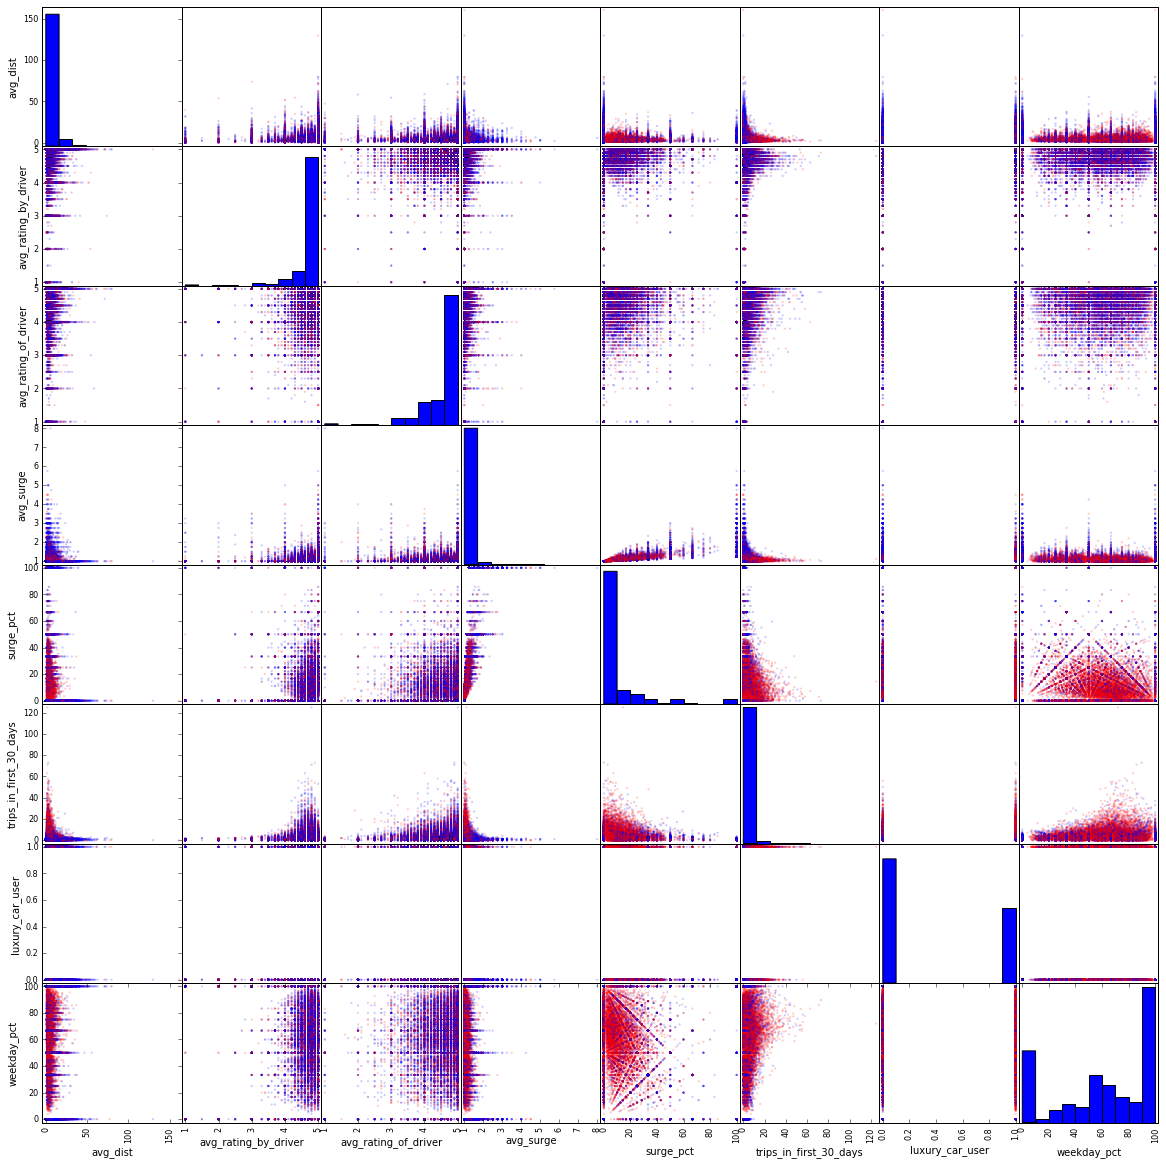

In [106]:
scatter_matrix(df[core_features], alpha=0.2, figsize=(20,20), diagonal='hist', color=colors)

In [122]:
def ttest_by(vals, by):
    vals1 = vals[by]
    vals2 = vals[-by]
    
    return sp.ttest_ind(vals1, vals2)

In [150]:
ttest_by(df.avg_dist, pd.isnull(df.avg_rating_by_driver))

Ttest_indResult(statistic=0.92179603168389357, pvalue=0.35663942563201456)

In [124]:
ttest_by(df.avg_dist, pd.isnull(df.avg_rating_of_driver))

Ttest_indResult(statistic=29.754284259108406, pvalue=7.407707064855626e-193)

In [168]:
dep_vars = [df.avg_dist, df.avg_surge, df.surge_pct, df.trips_in_first_30_days, df.weekday_pct]
ind_vars = [df.avg_rating_by_driver, df.avg_rating_of_driver]

for iv in ind_vars:
    print "independant: {}: ".format(iv.name)
    print "dependant list: "
    
    for dv in dep_vars:    
        stat, pval = ttest_by(dv, pd.isnull(iv))
        if pval < 0.05:
            print "  - {:22s}(stat: {:.4f}, pvalue: {:.4f})".format(dv.name, stat, pval)
    print "\n"

independant: avg_rating_by_driver: 
dependant list: 
  - avg_surge             (stat: 5.8200, pvalue: 0.0000)
  - surge_pct             (stat: 4.9160, pvalue: 0.0000)
  - trips_in_first_30_days(stat: -6.4675, pvalue: 0.0000)
  - weekday_pct           (stat: -2.9472, pvalue: 0.0032)


independant: avg_rating_of_driver: 
dependant list: 
  - avg_dist              (stat: 29.7543, pvalue: 0.0000)
  - trips_in_first_30_days(stat: -44.6082, pvalue: 0.0000)
  - weekday_pct           (stat: -4.9808, pvalue: 0.0000)




In [171]:
ttest_by(df.avg_dist, pd.isnull(df.avg_rating_by_driver))

Ttest_indResult(statistic=0.92179603168389357, pvalue=0.35663942563201456)

In [135]:
df.avg_dist.name

'avg_dist'

In [109]:
df.apply(lambda x: np.sum(pd.isnull(x)))

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                        0
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
is_active                    0
b_churned                    0
signup_year                  0
signup_month                 0
last_trip_year               0
last_trip_month              0
dtype: int64

In [172]:
df['b_no_rating_of_driver'] = pd.isnull(df.avg_rating_of_driver)

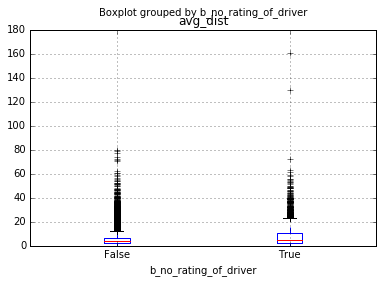

In [173]:
df.boxplot('avg_dist', by='b_no_rating_of_driver')

In [174]:
df2 = df[pd.notnull(df.avg_rating_by_driver)]

In [175]:
df2.apply(lambda x: np.sum(pd.isnull(x)))

avg_dist                     0
avg_rating_by_driver         0
avg_rating_of_driver      8055
avg_surge                    0
city                         0
last_trip_date               0
phone                        0
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
is_active                    0
b_churned                    0
signup_year                  0
signup_month                 0
last_trip_year               0
last_trip_month              0
b_no_rating_of_driver        0
dtype: int64

In [176]:
pd.crosstab(df.b_churned, df.is_active)

is_active,False,True
b_churned,,
False,0,18310
True,31690,0


In [177]:
pd.crosstab(df2.b_churned, df2.is_active)

is_active,False,True
b_churned,,
False,0,18276
True,31523,0


In [181]:
df3 = df[pd.notnull(df.avg_rating_of_driver)]

In [182]:
pd.crosstab(df3.b_churned, df3.is_active)

is_active,False,True
b_churned,,
False,0,16742
True,25136,0


In [185]:
df.groupby('b_no_rating_of_driver').describe().T

b_no_rating_of_driver                False        True 
avg_dist               count  41878.000000  8122.000000
                       mean       5.465290     7.506267
                       std        5.151833     7.758616
                       min        0.000000     0.000000
                       25%        2.420000     2.410000
                       50%        3.790000     4.715000
                       75%        6.490000    10.720000
                       max       79.690000   160.960000
avg_rating_by_driver   count  41744.000000  8055.000000
                       mean       4.776648     4.785984
                       std        0.404109     0.622122
                       min        1.000000     1.000000
                       25%        4.700000     5.000000
                       50%        5.000000     5.000000
                       75%        5.000000     5.000000
                       max        5.000000     5.000000
avg_rating_of_driver   count  41878.000000     0.000000
                       mean       4.601559          NaN
                       std        0.617338          NaN
                       min        1.000000          NaN
                       25%        4.300000          NaN
                       50%        4.900000          NaN
                       75%        5.000000          NaN
                       max        5.000000          NaN
avg_surge              count  41878.000000  8122.000000
                       mean       1.074095     1.078210
                       std        0.200861     0.310306
                       min        1.000000     1.000000
                       25%        1.000000     1.000000
                       50%        1.000000     1.000000
...                                    ...          ...
signup_year            std        0.000000     0.000000
                       min     2014.000000  2014.000000
                       25%     2014.000000  2014.000000
                       50%     2014.000000  2014.000000
                       75%     2014.000000  2014.000000
                       max     2014.000000  2014.000000
surge_pct              count  41878.000000  8122.000000
                       mean       8.908004     8.548067
                       std       18.401140    26.578461
                       min        0.000000     0.000000
                       25%        0.000000     0.000000
                       50%        0.000000     0.000000
                       75%       11.100000     0.000000
                       max      100.000000   100.000000
trips_in_first_30_days count  41878.000000  8122.000000
                       mean       2.604972     0.593327
                       std        4.055311     0.606755
                       min        0.000000     0.000000
                       25%        0.000000     0.000000
                       50%        1.000000     1.000000
                       75%        3.000000     1.000000
                       max      125.000000     5.000000
weekday_pct            count  41878.000000  8122.000000
                       mean      61.289756    59.050948
                       std       34.858046    46.859739
                       min        0.000000     0.000000
                       25%       37.500000     0.000000
                       50%       66.700000   100.000000
                       75%      100.000000   100.000000
                       max      100.000000   100.000000

[88 rows x 2 columns]

In [186]:
df.groupby('is_active').describe().T

is_active                            False         True 
avg_dist               count  31690.000000  18310.000000
                       mean       6.188478      5.118977
                       std        6.213027      4.627946
                       min        0.000000      0.000000
                       25%        2.320000      2.560000
                       50%        4.030000      3.730000
                       75%        7.770000      5.880000
                       max      129.890000    160.960000
avg_rating_by_driver   count  31523.000000  18276.000000
                       mean       4.786876      4.763121
                       std        0.503869      0.324566
                       min        1.000000      1.000000
                       25%        4.800000      4.700000
                       50%        5.000000      4.800000
                       75%        5.000000      5.000000
                       max        5.000000      5.000000
avg_rating_of_driver   count  25136.000000  16742.000000
                       mean       4.607018      4.593364
                       std        0.664816      0.538166
                       min        1.000000      1.000000
                       25%        4.400000      4.300000
                       50%        5.000000      4.800000
                       75%        5.000000      5.000000
                       max        5.000000      5.000000
avg_surge              count  31690.000000  18310.000000
                       mean       1.075367      1.073720
                       std        0.250219      0.163183
                       min        1.000000      1.000000
                       25%        1.000000      1.000000
                       50%        1.000000      1.000000
...                                    ...           ...
signup_year            std        0.000000      0.000000
                       min     2014.000000   2014.000000
                       25%     2014.000000   2014.000000
                       50%     2014.000000   2014.000000
                       75%     2014.000000   2014.000000
                       max     2014.000000   2014.000000
surge_pct              count  31690.000000  18310.000000
                       mean       8.688548      9.128165
                       std       22.132211     15.489344
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        0.000000      0.000000
                       75%        0.000000     13.300000
                       max      100.000000    100.000000
trips_in_first_30_days count  31690.000000  18310.000000
                       mean       1.659167      3.349590
                       std        2.661903      5.020615
                       min        0.000000      0.000000
                       25%        0.000000      0.000000
                       50%        1.000000      2.000000
                       75%        2.000000      4.000000
                       max       73.000000    125.000000
weekday_pct            count  31690.000000  18310.000000
                       mean      60.181597     62.214604
                       std       40.985698     29.068319
                       min        0.000000      0.000000
                       25%       16.700000     45.500000
                       50%       66.700000     65.200000
                       75%      100.000000     85.700000
                       max      100.000000    100.000000

[88 rows x 2 columns]

### Rating Data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x150f62a50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x14f074490>], dtype=object)

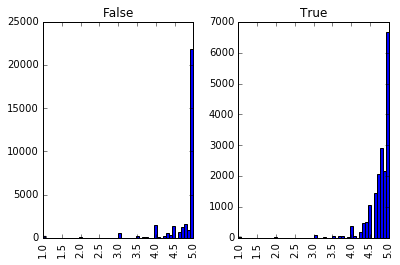

In [190]:
df.avg_rating_by_driver.hist(bins=50, histtype='bar', by=df.is_active, stacked=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14f316390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x137613e50>], dtype=object)

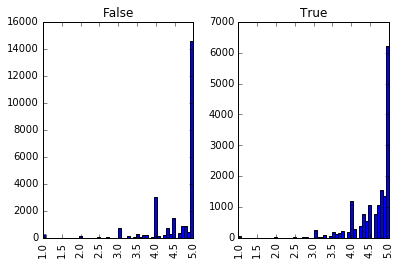

In [191]:
df.avg_rating_of_driver.hist(bins=50, histtype='bar', by=df.is_active, stacked=True)

In [192]:
df['b_5_rating'] = (df['avg_rating_of_driver'] == 5)

In [196]:
pd.crosstab(df.b_5_rating, df.is_active, margins=True)

is_active,False,True,All
b_5_rating,,,
False,17134,12095,29229
True,14556,6215,20771
All,31690,18310,50000


### Missing data solution

In [205]:
df['bin_avg_rating_by_driver'] = pd.cut(df.avg_rating_by_driver, bins=[0, 2.99, 3.99, 4.99, 5], 
                                        include_lowest=True, right=True)
df['bin_avg_rating_of_driver'] = pd.cut(df.avg_rating_of_driver, bins=[0, 2.99, 3.99, 4.99, 5], 
                                        include_lowest=True, right=True)

In [208]:
pd.crosstab(df.bin_avg_rating_by_driver, df.b_5_rating)

b_5_rating,False,True
bin_avg_rating_by_driver,,
"(-0.001, 2.99]",232,116
"(2.99, 3.99]",753,468
"(3.99, 4.99]",13621,6101
"(4.99, 5.0]",14519,13989


In [210]:
pd.crosstab(df.bin_avg_rating_of_driver, df.b_5_rating)

b_5_rating,False,True
bin_avg_rating_of_driver,,
"(-0.001, 2.99]",701,0
"(2.99, 3.99]",3111,0
"(3.99, 4.99]",17295,0
"(4.99, 5.0]",0,20771


In [211]:
pd.crosstab(df.bin_avg_rating_of_driver, df.is_active)

is_active,False,True
bin_avg_rating_of_driver,,
"(-0.001, 2.99]",522,179
"(2.99, 3.99]",1735,1376
"(3.99, 4.99]",8323,8972
"(4.99, 5.0]",14556,6215


In [212]:
pd.crosstab(df.bin_avg_rating_by_driver, df.is_active)

is_active,False,True
bin_avg_rating_by_driver,,
"(-0.001, 2.99]",309,39
"(2.99, 3.99]",948,273
"(3.99, 4.99]",8428,11294
"(4.99, 5.0]",21838,6670


In [215]:
df.bin_avg_rating_by_driver.cat.add_categories('missing', inplace=True)
df.bin_avg_rating_of_driver.cat.add_categories('missing', inplace=True)

In [219]:
df.bin_avg_rating_by_driver.fillna('missing', inplace=True)
df.bin_avg_rating_of_driver.fillna('missing', inplace=True)

In [220]:
df.bin_avg_rating_of_driver.value_counts()

(4.99, 5.0]       20771
(3.99, 4.99]      17295
missing            8122
(2.99, 3.99]       3111
(-0.001, 2.99]      701
Name: bin_avg_rating_of_driver, dtype: int64

In [221]:
df.bin_avg_rating_by_driver.value_counts()

(4.99, 5.0]       28508
(3.99, 4.99]      19722
(2.99, 3.99]       1221
(-0.001, 2.99]      348
missing             201
Name: bin_avg_rating_by_driver, dtype: int64

In [223]:
pd.crosstab(df.bin_avg_rating_by_driver, df.bin_avg_rating_of_driver, margins=True)

bin_avg_rating_of_driver,"(-0.001, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5.0]",missing,All
bin_avg_rating_by_driver,,,,,,
"(-0.001, 2.99]",23,25,39,116,145,348
"(2.99, 3.99]",52,125,319,468,257,1221
"(3.99, 4.99]",236,1757,10721,6101,907,19722
"(4.99, 5.0]",382,1196,6195,13989,6746,28508
missing,8,8,21,97,67,201
All,701,3111,17295,20771,8122,50000


In [230]:
df_dummy_by = pd.get_dummies(df.bin_avg_rating_by_driver)
df_dummy_by.apply(lambda x: x.value_counts())

,"(-0.001, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5.0]",missing
0,49652,48779,30278,21492,49799
1,348,1221,19722,28508,201


In [231]:
df_dummy_of = pd.get_dummies(df.bin_avg_rating_of_driver)
df_dummy_of.apply(lambda x: x.value_counts())

,"(-0.001, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5.0]",missing
0,49299,46889,32705,29229,41878
1,701,3111,17295,20771,8122


In [233]:
df_dummy_by.columns = map(lambda x: 'bin_by_driver' + str(x), df_dummy_by.columns)

In [235]:
df_dummy_of.columns = map(lambda x: 'bin_of_driver' + str(x), df_dummy_of.columns)

In [237]:
df_dummy_phone = pd.get_dummies(df.phone)
df_dummy_city = pd.get_dummies(df.city)

In [251]:
df_all = pd.concat([df.avg_dist, df_dummy_phone, df_dummy_city, df.ix[:,['surge_pct', 'trips_in_first_30_days', 
                    'luxury_car_user', 'weekday_pct', 'is_active']], df_dummy_by, df_dummy_of], axis=1)

In [252]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
avg_dist                       50000 non-null float64
Android                        50000 non-null uint8
iPhone                         50000 non-null uint8
no_phone                       50000 non-null uint8
Astapor                        50000 non-null uint8
King's Landing                 50000 non-null uint8
Winterfell                     50000 non-null uint8
surge_pct                      50000 non-null float64
trips_in_first_30_days         50000 non-null int64
luxury_car_user                50000 non-null bool
weekday_pct                    50000 non-null float64
is_active                      50000 non-null bool
bin_by_driver(-0.001, 2.99]    50000 non-null uint8
bin_by_driver(2.99, 3.99]      50000 non-null uint8
bin_by_driver(3.99, 4.99]      50000 non-null uint8
bin_by_driver(4.99, 5.0]       50000 non-null uint8
bin_by_drivermissing           50000 non-null uint8
bin

In [255]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
Android,50000.0,0.300440,0.458454,0.0,0.00,0.00,1.00,1.00
iPhone,50000.0,0.691640,0.461821,0.0,0.00,1.00,1.00,1.00
no_phone,50000.0,0.007920,0.088642,0.0,0.00,0.00,0.00,1.00
Astapor,50000.0,0.330680,0.470463,0.0,0.00,0.00,1.00,1.00
King's Landing,50000.0,0.202600,0.401941,0.0,0.00,0.00,0.00,1.00
Winterfell,50000.0,0.466720,0.498896,0.0,0.00,0.00,1.00,1.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


## Modeling

### First model

In [259]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

### Code to plot ROC curve

In [385]:
def roc_curve(probabilities, labels):
    thresholds = np.sort(probabilities)
    tprs = []
    fprs = []
    
    num_postive_cases = sum(labels)
    num_negative_cases = len(labels) - num_postive_cases
    
    for threshold in thresholds:
        predicted_positive = probabilities >= threshold
        true_positives = np.sum(predicted_positive * labels)
        false_positives = np.sum(predicted_positive) - true_positives
        
        tpr = true_positives / float(num_postive_cases)
        fpr = false_positives / float(num_negative_cases)
        tprs.append(tpr)
        fprs.append(fpr)
    
    return tprs, fprs, thresholds.tolist()

In [396]:
def plot_roc(probs, y_test, title, xlabel, ylabel):
    tpr, fpr, thresholds = roc_curve(probs, y_test)
    plt.hold(True)
    plt.plot(fpr, tpr)
    plt.title(title)
    
    xx = np.linspace(0, 1.0, 20)
    plt.plot(xx, xx, color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [279]:
v_features = df_all.columns
v_features = v_features.tolist()
v_features_i = v_features[:]
del v_features_i[v_features_i.index('is_active')]

In [298]:
X = df_all.loc[:, v_features_i]
y = df_all.is_active.astype('int')

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67)

### First crappy model: Logistic Regression

In [335]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [460]:
lr_score = lr.score(X_test, y_test)
print lr_score

0.7482


In [340]:
v_probs = lr.predict_proba(X_test)[:, 1]

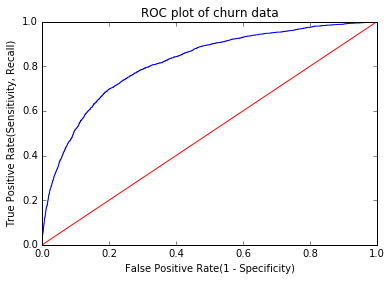

In [397]:
plot_roc(v_probs, y_test, "ROC plot of churn data", "False Positive Rate(1 - Specificity)", "True Positive Rate(Sensitivity, Recall)")

In [399]:
import sklearn.metrics as skm 

In [433]:
skm.roc_auc_score(y_test, lr.predict(X_test))

0.7468694104315784

In [430]:
pd.crosstab(y_test, lr.predict(X_test))

col_0,0,1
is_active,,
0,4771,1575
1,943,2711


In [471]:
pd.crosstab(y_train, lr.predict(X_train))

col_0,0,1
is_active,,
0,18828,6516
1,3785,10871


In [453]:
def plot_confusion_matrix(model, X_test, y_test):
    cm = skm.confusion_matrix(y_test, model.predict(X_test))
    print cm
    
    plt.matshow(cm)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

[[4771 1575]
 [ 943 2711]]


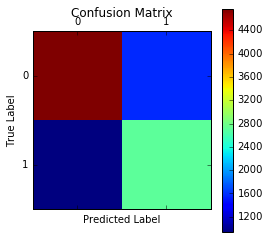

In [454]:
plot_confusion_matrix(lr, X_test, y_test)

### A slightly better crappy model: gradient boosting classification trees
The non-linear nature of the problem makes decision trees appealing. But it makes sense to use an ensemble model(random forest, gradient boosting) to get the better performance.

In [443]:
from sklearn.ensemble import GradientBoostingClassifier

In [444]:
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=8, subsample=0.5, learning_rate=0.05, max_features='auto')
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=0.5, verbose=0, warm_start=False)

In [461]:
gbc_score = gbc.score(X_test, y_test)
print gbc_score

0.788


In [449]:
pd.crosstab(y_test, gbc.predict(X_test))

col_0,0,1
is_active,,
0,5446,900
1,1220,2434


In [472]:
pd.crosstab(y_train, gbc.predict(X_train))

col_0,0,1
is_active,,
0,24092,1252
1,2560,12096


In [450]:
skm.roc_auc_score(y_test, gbc.predict(X_test))

0.76214885068683813

[[5446  900]
 [1220 2434]]


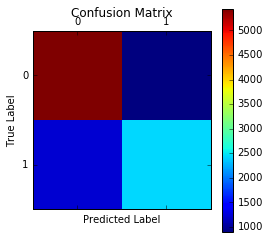

In [455]:
plot_confusion_matrix(gbc, X_test, y_test)

### Random Forest

In [456]:
from sklearn.ensemble import RandomForestClassifier

In [457]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='auto')

In [458]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [462]:
rfc_score = rfc.score(X_test, y_test)
print rfc_score

0.7517


In [467]:
print "Logistic Regression: %.4f" % lr_score
print "Gradient Boosting: %.4f" % gbc_score
print "Random Forest: %.4f" % rfc_score

Logistic Regression: 0.7482
Gradient Boosting: 0.7880
Random Forest: 0.7517


In [468]:
pd.crosstab(y_test, rfc.predict(X_test))

col_0,0,1
is_active,,
0,5138,1208
1,1275,2379


In [473]:
pd.crosstab(y_train, rfc.predict(X_train))

col_0,0,1
is_active,,
0,25275,69
1,61,14595


In [474]:
skm.roc_auc_score(y_test, rfc.predict(X_test))

0.73035559681777229

[[5138 1208]
 [1275 2379]]


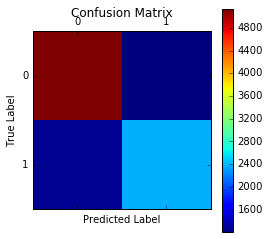

In [475]:
plot_confusion_matrix(rfc, X_test, y_test)

### Refine model
Now we try several tings:
- Scale data
- Use grid search to find the best tuning of each model
- Compare different classification models
- Explore feature engineering
- Tune with profit curve based on costs of different classification errors

In [480]:
X[['avg_dist', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct']].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


In [481]:
from sklearn.preprocessing import scale

In [490]:
X.avg_dist = scale(X.avg_dist)
X.surge_pct = scale(X.surge_pct)
X.trips_in_first_30_days = scale(X.trips_in_first_30_days.astype('float'))
X.weekday_pct = scale(X.weekday_pct)

In [492]:
X[['avg_dist', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct']].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,-1.371681e-17,1.00001,-1.015686,-0.591668,-0.335855,0.200300,27.186793
surge_pct,50000.0,7.014833e-16,1.00001,-0.443394,-0.443394,-0.443394,-0.012503,4.566974
trips_in_first_30_days,50000.0,-8.705436e-16,1.00001,-0.600689,-0.600689,-0.337021,0.190316,32.357830
weekday_pct,50000.0,1.350848e-15,1.00001,-1.643048,-0.745017,0.155710,1.053741,1.053741


In [493]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
avg_dist                       50000 non-null float64
Android                        50000 non-null uint8
iPhone                         50000 non-null uint8
no_phone                       50000 non-null uint8
Astapor                        50000 non-null uint8
King's Landing                 50000 non-null uint8
Winterfell                     50000 non-null uint8
surge_pct                      50000 non-null float64
trips_in_first_30_days         50000 non-null float64
luxury_car_user                50000 non-null bool
weekday_pct                    50000 non-null float64
bin_by_driver(-0.001, 2.99]    50000 non-null uint8
bin_by_driver(2.99, 3.99]      50000 non-null uint8
bin_by_driver(3.99, 4.99]      50000 non-null uint8
bin_by_driver(4.99, 5.0]       50000 non-null uint8
bin_by_drivermissing           50000 non-null uint8
bin_of_driver(-0.001, 2.99]    50000 non-null uint8


In [494]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=67)

### Refine gradient boosting model via grid search

In [496]:
from sklearn.grid_search import GridSearchCV

Setup grid to search

In [513]:
gbc_grid = {
    'learning_rate': [0.05, 0.01, 0.005],
    'max_depth': [6, 8, 10],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [2, 4],
    'subsample': [0.25, 0.5],
    'n_estimators': [500, 1000]
}

#Refined grid search
gbc_grid = {
    'learning_rate': [0.01],
    'max_depth': [6],
    'max_features': [None],
    'min_samples_leaf': [2],
    'subsample': [0.25],
    'n_estimators': [1000]    
}

In [504]:
gbc_grid_cv = GridSearchCV(GradientBoostingClassifier(), gbc_grid, n_jobs=-1)

In [505]:
gbc_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01], 'min_samples_leaf': [2], 'n_estimators': [1000], 'subsample': [0.25], 'max_features': [None], 'max_depth': [6]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [512]:
best_model = gbc_grid_cv.best_estimator_
best_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=2,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=0.25, verbose=0, warm_start=False)

In [509]:
best_params = gbc_grid_cv.best_params_
best_params

{'learning_rate': 0.01,
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 2,
 'n_estimators': 1000,
 'subsample': 0.25}

In [510]:
best_score = gbc_grid_cv.best_score_
best_score

0.7939

In [514]:
skm.roc_auc_score(y_test, best_model.predict(X_test))

0.77005258345119465

In [618]:
def plot_feature_importance(b_model, X, max_features=10):
    feature_importance = b_model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    pos = pos[-max_features:]
    
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature_names = X.columns[sorted_idx][-max_features:]

    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

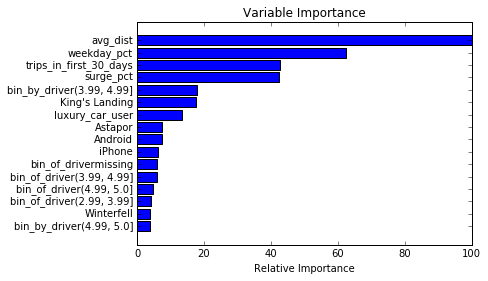

In [619]:
plot_feature_importance(best_model, X_train, max_features=16)

In [673]:
def plot_loss(clf, params):
    '''Plot training deviance'''
    test_score = np.zeros((best_params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(best_model.staged_decision_function(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)
        
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-', label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Deviance')
    plt.xlabel('Boosting Iterations')
    plt.ylabel(clf.loss)
    plt.legend(loc='upper right')

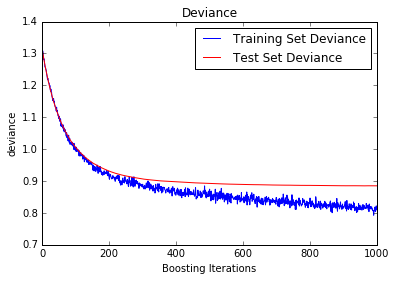

In [674]:
plot_loss(best_model, best_params)

[[5522  824]
 [1206 2448]]


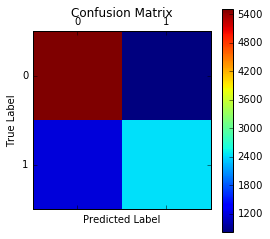

In [675]:
plot_confusion_matrix(best_model, X_test, y_test)

### Refine random forest model via grid search

In [679]:
rfc_grid = {
    'max_depth': [4, 8, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True],
    'n_estimators': [50, 100, 200, 400],
    'random_state': [67],
    'oob_score': [True],
    'n_jobs': [-1]
}

In [680]:
rf_grid_cv = GridSearchCV(RandomForestClassifier(), rfc_grid, n_jobs=-1, verbose=True, scoring='roc_auc')

In [681]:
rf_grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 12.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 400], 'min_samples_split': [2, 4], 'oob_score': [True], 'random_state': [67], 'n_jobs': [-1], 'max_features': ['sqrt', 'log2', None], 'bootstrap': [True], 'max_depth': [4, 8, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [682]:
rfc_best_params = rf_grid_cv.best_params_
rfc_best_params

{'bootstrap': True,
 'max_depth': 8,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 67}

In [683]:
rfc_best_score = rf_grid_cv.best_score_
rfc_best_score

0.8488779044278235

In [685]:
rfc_best_model = rf_grid_cv.best_estimator_

In [687]:
rfc_best_model.oob_score_

0.78425

In [688]:
skm.roc_auc_score(y_test, rfc_best_model.predict(X_test))

0.76129471245047731

[[5456  890]
 [1232 2422]]


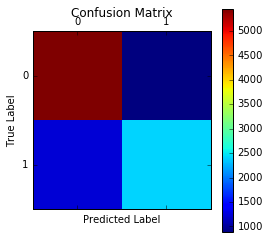

In [689]:
plot_confusion_matrix(rfc_best_model, X_test, y_test)

### AUC and confusion matrix suggest that the gradient boosting model is better than random forest

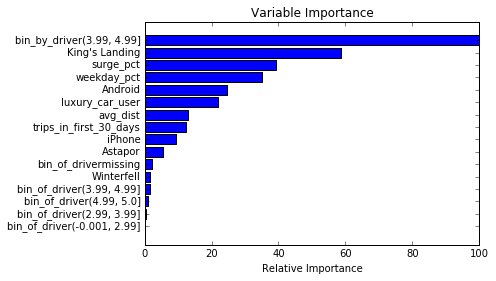

In [690]:
plot_feature_importance(rfc_best_model, X_train, max_features=16)

In [691]:
m_oob = rfc_best_model.oob_decision_function_

### Check OOB error rate to see that random forest stabilized

In [694]:
min_estimators = 10
max_estimators = 400
error_rate = []

In [695]:
from sklearn.base import clone

In [697]:
best_rfc_clf = RandomForestClassifier(bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=2,
    min_samples_split=2, n_estimators=400, n_jobs=-1, oob_score=True, random_state=67)

In [703]:
for num_estimators in range(min_estimators, max_estimators+1, 10):
    clf = clone(best_rfc_clf)
    clf.set_params(n_estimators=num_estimators)
    print "Fitting with {} estimators".format(num_estimators)
    clf.fit(X_train, y_train)
    print "OOB Score: {}".format(clf.oob_score_)
    oob_error = 1 - clf.oob_score_
    error_rate.append((num_estimators, oob_error))

Fitting with 10 estimators


/Users/alexseong/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexseong/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


OOB Score: 0.7782
Fitting with 20 estimators
OOB Score: 0.782125
Fitting with 30 estimators
OOB Score: 0.78225
Fitting with 40 estimators
OOB Score: 0.782675
Fitting with 50 estimators
OOB Score: 0.783675
Fitting with 60 estimators
OOB Score: 0.7837
Fitting with 70 estimators
OOB Score: 0.783625
Fitting with 80 estimators
OOB Score: 0.784275
Fitting with 90 estimators
OOB Score: 0.784125
Fitting with 100 estimators
OOB Score: 0.78395
Fitting with 110 estimators
OOB Score: 0.7838
Fitting with 120 estimators
OOB Score: 0.783875
Fitting with 130 estimators
OOB Score: 0.784075
Fitting with 140 estimators
OOB Score: 0.783975
Fitting with 150 estimators
OOB Score: 0.784025
Fitting with 160 estimators
OOB Score: 0.7838
Fitting with 170 estimators
OOB Score: 0.78405
Fitting with 180 estimators
OOB Score: 0.784225
Fitting with 190 estimators
OOB Score: 0.784125
Fitting with 200 estimators
OOB Score: 0.78425
Fitting with 210 estimators
OOB Score: 0.784375
Fitting with 220 estimators
OOB Score: 0

In [712]:
oob_error_rate = np.array(error_rate)

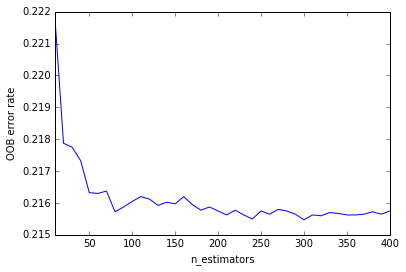

In [719]:
plt.plot(oob_error_rate[:, 0], oob_error_rate[:, 1])
plt.xlim(min_estimators, max_estimators)
plt.xlabel('n_estimators')
plt.ylabel('OOB error rate')

Looks like OOB error rate has stabilized around 300 or so estimators

### Profit curve
Should refine using data about costs of misclassification. Should talk to product manager to get relevant economic costs and benefits for retention

## Report: conclusions and recommendations
Now, present results and recommendations.

Analysis should focus on the marginal consumer(the one indifferent between using the service and not) because these are the consumers we can most easily affect with incentives